In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from typing import Tuple

In [10]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dagiM\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
def load_news_dataset(path: str) -> pd.DataFrame:
    return pd.read_csv(path, parse_dates=['date'])

def load_stock_data(ticker: str, directory: str) -> pd.DataFrame:
    file_path = os.path.join(directory, f"{ticker}_historical_data.csv")
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df.rename(columns={'Date': 'date'}, inplace=True)
    df['ticker'] = ticker
    return df

def compute_sentiment_scores(news_df: pd.DataFrame) -> pd.DataFrame:
    sid = SentimentIntensityAnalyzer()
    news_df['sentiment'] = news_df['headline'].apply(lambda x: sid.polarity_scores(str(x))['compound'])
    return news_df

def aggregate_daily_sentiment(news_df: pd.DataFrame) -> pd.DataFrame:
    return news_df.groupby('date')['sentiment'].mean().reset_index()

def calculate_daily_returns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(['ticker', 'date'])
    df['daily_return'] = df.groupby('ticker')['Close'].pct_change()
    return df


def merge_stock_sentiment(stock_df: pd.DataFrame, sentiment_df: pd.DataFrame) -> pd.DataFrame:
    # Normalize stock dates
    stock_df['date'] = pd.to_datetime(stock_df['date'], errors='coerce')
    stock_df['date'] = stock_df['date'].dt.tz_localize(None).dt.normalize()

    # Normalize sentiment/news dates
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')
    sentiment_df['date'] = sentiment_df['date'].dt.tz_localize(None).dt.normalize()

    # Merge on date
    return pd.merge(stock_df, sentiment_df, on='date', how='inner')



def compute_correlation_per_ticker(merged_df: pd.DataFrame) -> pd.DataFrame:
    results = (
        merged_df.groupby('ticker')[['daily_return', 'sentiment']]
        .corr()
        .iloc[0::2, -1]  # Extract correlation between daily_return and sentiment
        .reset_index()
        .rename(columns={'sentiment': 'correlation'})[['ticker', 'correlation']]
    )
    return results

def plot_correlations(corr_df: pd.DataFrame):
    plt.figure(figsize=(10, 5))
    sns.barplot(data=corr_df, x='ticker', y='correlation', palette='coolwarm')
    plt.title("Pearson Correlation: Sentiment vs Daily Return")
    plt.ylabel("Correlation Coefficient")
    plt.xlabel("Ticker")
    plt.axhline(0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()

In [17]:
TICKERS = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
STOCK_DATA_DIR = "../Data/yfinance_data"
NEWS_DATA_PATH = "../Data/raw_analyst_ratings/raw_analyst_ratings.csv"


news_df = load_news_dataset(NEWS_DATA_PATH)
stock_dfs = [load_stock_data(ticker, STOCK_DATA_DIR) for ticker in TICKERS]
combined_stock_df = pd.concat(stock_dfs, ignore_index=True)


In [18]:
news_df = compute_sentiment_scores(news_df)
daily_sentiment = aggregate_daily_sentiment(news_df)

In [19]:
 # Stock return processing
combined_stock_df = calculate_daily_returns(combined_stock_df)

In [27]:
# Merge and correlate
merged_df = merge_stock_sentiment(combined_stock_df, daily_sentiment)
correlation_df = compute_correlation_per_ticker(merged_df)

In [28]:
print(correlation_df)

  ticker  correlation
0   AAPL     0.148743
1   AMZN     0.084265
2   GOOG     0.132860
3   META     0.122209
4   MSFT     0.129073
5   NVDA     0.123376
6   TSLA     0.118395


C:\Users\dagiM\AppData\Local\Temp\ipykernel_9824\835600708.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df, x='ticker', y='correlation', palette='coolwarm')


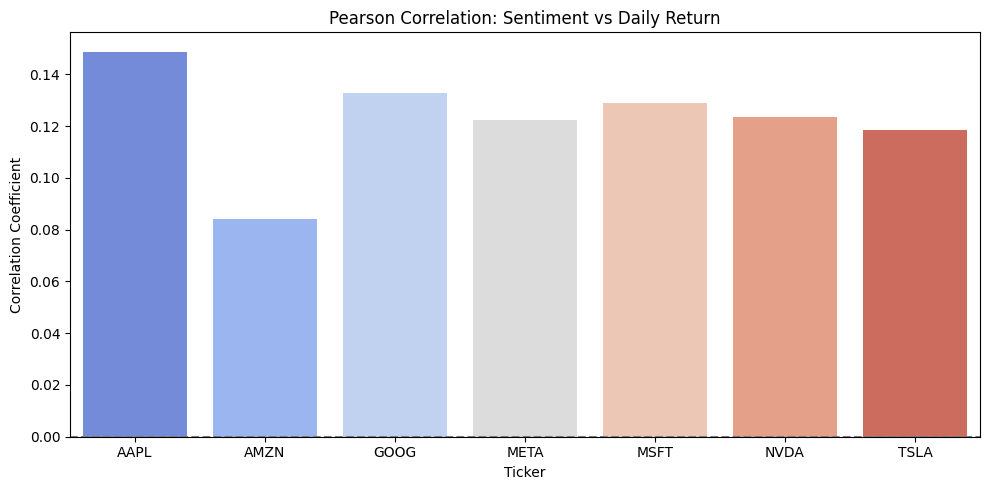

In [29]:
plot_correlations(correlation_df)